In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sys.path.append(os.path.abspath('../src'))
path_to_py = os.path.abspath('../src')

In [5]:
# Load the cleaned dataset
df = pd.read_csv(os.path.join(path_to_py, "data", "cleaned_train.csv"))

















In [6]:
# Initial check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189457 entries, 0 to 189456
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    189457 non-null  int64  
 1   term                         189457 non-null  object 
 2   int_rate                     189457 non-null  float64
 3   emp_length                   189457 non-null  float64
 4   home_ownership               189457 non-null  object 
 5   annual_inc                   189457 non-null  float64
 6   purpose                      189457 non-null  object 
 7   percent_bc_gt_75             189457 non-null  float64
 8   bc_util                      189457 non-null  float64
 9   dti                          189457 non-null  float64
 10  inq_last_6mths               189457 non-null  float64
 11  mths_since_recent_inq        189457 non-null  float64
 12  revol_util                   189457 non-null  float64
 13 

In [7]:
print("\nFeature names:", df.columns.tolist())



Feature names: ['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'percent_bc_gt_75', 'bc_util', 'dti', 'inq_last_6mths', 'mths_since_recent_inq', 'revol_util', 'total_bc_limit', 'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal', 'internal_score', 'bad_flag', 'no_credit_card_history', 'no_derog_history', 'emp_length_missing']


In [8]:
print("\nData types:\n", df.dtypes)


Data types:
 loan_amnt                        int64
term                            object
int_rate                       float64
emp_length                     float64
home_ownership                  object
annual_inc                     float64
purpose                         object
percent_bc_gt_75               float64
bc_util                        float64
dti                            float64
inq_last_6mths                 float64
mths_since_recent_inq          float64
revol_util                     float64
total_bc_limit                 float64
mths_since_last_major_derog    float64
tot_hi_cred_lim                float64
tot_cur_bal                    float64
internal_score                   int64
bad_flag                       float64
no_credit_card_history           int64
no_derog_history                 int64
emp_length_missing               int64
dtype: object


## Categorical Feature Encoding

Based on our EDA:
- Home ownership: Ordinal encoding based on default rates
    - MORTGAGE (5.83%) -> 0
    - OWN (7%) -> 1
    - RENT (8.4%) -> 2
    - NONE (9.5%) -> 3
    - OTHER (10.87%) -> 4

- Loan Purpose: Risk-based groupings then encode
    - Low risk (credit_card, home_improvement) -> 0
    - Medium risk (debt_consolidation, car, major_purchase) -> 1
    - High risk (small_business, renewable_energy) -> 2

In [9]:
# Home ownership encoding based on default rates (ascending order of risk)
home_ownership_risk = {
    'MORTGAGE': 0,  # 5.83%
    'OWN': 1,      # 7.00%
    'RENT': 2,     # 8.40%
    'NONE': 3,     # 9.50%
    'OTHER': 4     # 10.87%
}

# Loan purpose risk-based grouping and encoding
# First, let's define risk groups based on default rates
low_risk_purpose = ['credit_card', 'home_improvement', 'car', 'major_purchase', 'debt_consolidation']
medium_risk_purpose = ['medical', 'moving', 'other', 'vacation', 'house', 'wedding']
high_risk_purpose = ['small_business', 'renewable_energy']

def encode_purpose(purpose):
    if purpose in low_risk_purpose:
        return 0
    elif purpose in medium_risk_purpose:
        return 1
    else:
        return 2

# Apply encodings
df['home_ownership_encoded'] = df['home_ownership'].map(home_ownership_risk)
df['purpose_encoded'] = df['purpose'].apply(encode_purpose)

# Binary encoding for term (36 months = 0, 60 months = 1)
df['term_encoded'] = df['term'].apply(lambda x: 0 if '36' in x else 1)

# Drop original categorical columns
df = df.drop(['home_ownership', 'purpose', 'term'], axis=1)

# Verify encodings
print("\nEncoded features check:")
for col in ['home_ownership_encoded', 'purpose_encoded', 'term_encoded']:
    print(f"\n{col} value counts:")
    print(df[col].value_counts().sort_index())

print("\nUpdated dataset shape:", df.shape)


Encoded features check:

home_ownership_encoded value counts:
home_ownership_encoded
0    97647
1    15573
2    76149
3       42
4       46
Name: count, dtype: int64

purpose_encoded value counts:
purpose_encoded
0    171695
1     14882
2      2880
Name: count, dtype: int64

term_encoded value counts:
term_encoded
0    144800
1     44657
Name: count, dtype: int64

Updated dataset shape: (189457, 22)


## Train-Val-Test Split

In [10]:
# Step 2: Train-Val-Test Split
# First split into train and temp (test + validation)
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['bad_flag'], random_state=42)
# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['bad_flag'], random_state=42)

print("Dataset shapes:")
print(f"Train: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Verify class distribution in splits
print("\nClass distribution in splits:")
print("Train:", train_df['bad_flag'].value_counts(normalize=True))
print("Validation:", val_df['bad_flag'].value_counts(normalize=True))
print("Test:", test_df['bad_flag'].value_counts(normalize=True))

Dataset shapes:
Train: (113674, 22)
Validation: (37891, 22)
Test: (37892, 22)

Class distribution in splits:
Train: bad_flag
0.0    0.930705
1.0    0.069295
Name: proportion, dtype: float64
Validation: bad_flag
0.0    0.930722
1.0    0.069278
Name: proportion, dtype: float64
Test: bad_flag
0.0    0.930698
1.0    0.069302
Name: proportion, dtype: float64


## Feature Transformations and Feature Engineering
1. Log transformation for right-skewed features
- annual_inc
- loan_amnt

2. Standard scaling for normally distributed features:
- int_rate
- dti
- revol_util
- bc_util

3. Feature Engineering
- Composite utilization feature (from revol_util and bc_util)
- Income-to-loan ratio (using log transformed values)
- Relevant interaction terms based on our EDA insights

**Implementation Strategy**:
1. Apply log transformations to all splits (no fitting required)
2. Fit scalers only on training data, then transform all splits
3. Create engineered features using the properly scaled values
4. Drop original features that have been transformed


In [11]:
# Scaling and Feature Transformations (fit only on training data)

# Log transformations first
for df_ in [train_df, val_df, test_df]:
    df_['log_annual_inc'] = np.log1p(df_['annual_inc'])
    df_['log_loan_amt'] = np.log1p(df_['loan_amnt'])
    df_['log_dti'] = np.log1p(df_['dti'])

# Standard scaling
scaler = StandardScaler()
scale_features = [
    'int_rate',
    'revol_util',
    'percent_bc_gt_75',
    'emp_length',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'total_bc_limit',
    'tot_hi_cred_lim',
    'tot_cur_bal'
]

# Fit scaler only on training data
scaler_dict = {}
for feature in scale_features:
    scaler_dict[feature] = StandardScaler()
    train_df[f'{feature}_scaled'] = scaler_dict[feature].fit_transform(train_df[[feature]])
    # Transform validation and test using the scaler fit on training data
    val_df[f'{feature}_scaled'] = scaler_dict[feature].transform(val_df[[feature]])
    test_df[f'{feature}_scaled'] = scaler_dict[feature].transform(test_df[[feature]])

# Special handling for mths_since_last_major_derog
# Create scaler for positive values only
derog_scaler = StandardScaler()

# Process training data
mask_train = train_df['mths_since_last_major_derog'] >= 0
train_df['mths_since_derog_scaled'] = train_df['mths_since_last_major_derog'].copy()
train_df.loc[mask_train, 'mths_since_derog_scaled'] = derog_scaler.fit_transform(
    train_df.loc[mask_train, ['mths_since_last_major_derog']])

# Process validation data
mask_val = val_df['mths_since_last_major_derog'] >= 0
val_df['mths_since_derog_scaled'] = val_df['mths_since_last_major_derog'].copy()
val_df.loc[mask_val, 'mths_since_derog_scaled'] = derog_scaler.transform(
    val_df.loc[mask_val, ['mths_since_last_major_derog']])

# Process test data
mask_test = test_df['mths_since_last_major_derog'] >= 0
test_df['mths_since_derog_scaled'] = test_df['mths_since_last_major_derog'].copy()
test_df.loc[mask_test, 'mths_since_derog_scaled'] = derog_scaler.transform(
    test_df.loc[mask_test, ['mths_since_last_major_derog']])

# Feature Engineering (using scaled features)
for df_ in [train_df, val_df, test_df]:
    
    # Income to loan ratio using log transformed values
    df_['income_to_loan_ratio'] = df_['log_annual_inc'] / df_['log_loan_amt']
    
    # Interest rate * DTI interaction
    df_['int_rate_dti'] = df_['int_rate_scaled'] * df_['log_dti']
    
    # Risk score
    df_['risk_score'] = (df_['int_rate_scaled'] + 
                        df_['log_dti'] + 
                        df_['revol_util_scaled'] - 
                        df_['income_to_loan_ratio'])

# Drop original features that have been transformed
columns_to_drop = scale_features + ['annual_inc', 'loan_amnt', 'dti', 'bc_util', 'internal_score', 'mths_since_last_major_derog']
train_df = train_df.drop(columns_to_drop, axis=1)
val_df = val_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

# Verify final shapes and features
print("\nFinal shapes:")
print(f"Train: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Check for any missing values
print("\nMissing values in final datasets:")
print("Train:", train_df.isnull().sum().sum())
print("Validation:", val_df.isnull().sum().sum())
print("Test:", test_df.isnull().sum().sum())

# Verify engineered features in training set
print("\nEngineered features summary in training set:")
engineered_features = ['income_to_loan_ratio', 'int_rate_dti', 'risk_score']
print(train_df[engineered_features].describe())


Final shapes:
Train: (113674, 23)
Validation: (37891, 23)
Test: (37892, 23)

Missing values in final datasets:
Train: 0
Validation: 0
Test: 0

Engineered features summary in training set:
       income_to_loan_ratio   int_rate_dti     risk_score
count         113674.000000  113674.000000  113674.000000
mean               1.181497       0.074440       1.600007
std                0.080044       2.805507       1.863076
min                1.050047      -6.648402      -5.717231
25%                1.124017      -1.889954       0.417555
50%                1.164238      -0.105668       1.733974
75%                1.218051       1.906417       2.919200
max                1.766755       9.341149       6.612324


**Strategy for Handling Class Imbalance**:
- Let's calculate class weights based on our training data rather than SMOTE or other resampling techniques which can lead to overfitting.
- The weights will be used later in the loss function when training the neural network model

In [12]:
# Calculate class weights using sklearn's balanced method
from sklearn.utils.class_weight import compute_class_weight

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Scikit-learn's balanced weights
balanced_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['bad_flag']),
    y=train_df['bad_flag']
)
balanced_weights_dict = dict(zip(np.unique(train_df['bad_flag']), balanced_weights))

# 2. Inverse frequency weights
neg_samples = (train_df['bad_flag'] == 0).sum()
pos_samples = (train_df['bad_flag'] == 1).sum()
total_samples = len(train_df)

inv_weights = {
   0: total_samples / (2 * neg_samples),
   1: total_samples / (2 * pos_samples)
}

# 3. Effective number weights
beta = 0.9999
En_neg = (1 - beta ** neg_samples) / (1 - beta)
En_pos = (1 - beta ** pos_samples) / (1 - beta)

eff_weights = {
   0: 1 / En_neg,
   1: 1 / En_pos
}

# # Convert to PyTorch tensor for later use
# class_weights_tensor = torch.FloatTensor([balanced_weights_dict[0], balanced_weights_dict[1]])

# print("Balanced class weights:")
# print(balanced_weights_dict)
# print("\nClass weights tensor:")
# print(class_weights_tensor)

# Print all weights for comparison
print("1. Scikit-learn balanced weights:")
print(balanced_weights_dict)
print("\n2. Inverse frequency weights:")
print(inv_weights)
print("\n3. Effective number weights:")
print(eff_weights)

# Convert all to tensors
balanced_weights_tensor = torch.FloatTensor([balanced_weights_dict[0], balanced_weights_dict[1]]).to(device)
inv_weights_tensor = torch.FloatTensor([inv_weights[0], inv_weights[1]]).to(device)
eff_weights_tensor = torch.FloatTensor([eff_weights[0], eff_weights[1]]).to(device)

print("\nClass weights tensors:")
print("1. Balanced:", balanced_weights_tensor)
print("2. Inverse:", inv_weights_tensor)
print("3. Effective:", eff_weights_tensor)

Using device: cpu
1. Scikit-learn balanced weights:
{0.0: 0.5372269535052979, 1.0: 7.215564301129872}

2. Inverse frequency weights:
{0: 0.5372269535052979, 1: 7.215564301129872}

3. Effective number weights:
{0: 0.00010000254141713908, 1: 0.0001834431287148764}

Class weights tensors:
1. Balanced: tensor([0.5372, 7.2156])
2. Inverse: tensor([0.5372, 7.2156])
3. Effective: tensor([0.0001, 0.0002])


**Observation**:
The class weights look good! The weights reflect the imbalance in our data:
- Majority class (0.0): weight ≈ 0.54
- Minority class (1.0): weight ≈ 7.22

This means the loss function will weigh errors on the minority class (bad loans) about 13.4 times more heavily than errors on the majority class (good loans), which aligns with our class distribution.

## Pytorch Tensors and Data Loaders

In [13]:
# Create PyTorch Dataset and DataLoader

# First, let's separate features and target for each split
def prepare_features_target(df):
   # Separate target
   y = df['bad_flag'].values
   # Drop target from features
   X = df.drop('bad_flag', axis=1).values
   return X, y

# Prepare data for all splits
X_train, y_train = prepare_features_target(train_df)
X_val, y_val = prepare_features_target(val_df)
X_test, y_test = prepare_features_target(test_df)

# Create PyTorch Dataset class
class LoanDataset(Dataset):
   def __init__(self, X, y):
       self.X = torch.FloatTensor(X)
       self.y = torch.FloatTensor(y)
   
   def __len__(self):
       return len(self.y)
   
   def __getitem__(self, idx):
       return self.X[idx], self.y[idx]

# Create Dataset objects
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)

# Create DataLoaders
batch_size = 128  # Can be tuned

train_loader = DataLoader(
   train_dataset, 
   batch_size=batch_size, 
   shuffle=True
)

val_loader = DataLoader(
   val_dataset, 
   batch_size=batch_size, 
   shuffle=False
)

test_loader = DataLoader(
   test_dataset, 
   batch_size=batch_size, 
   shuffle=False
)

# Verify the dataloaders
print("Number of features:", X_train.shape[1])
print("\nDataLoader sizes:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify a batch
X_batch, y_batch = next(iter(train_loader))
print("\nBatch shapes:")
print(f"X batch shape: {X_batch.shape}")
print(f"y batch shape: {y_batch.shape}")

Number of features: 22

DataLoader sizes:
Training batches: 889
Validation batches: 297
Test batches: 297

Batch shapes:
X batch shape: torch.Size([128, 22])
y batch shape: torch.Size([128])


## Neural Network Architecture
**Characteristics**:
- Input features: 22
- Binary classification task
- Imbalanced features
- Mix of numerical and encoded categorical features

1. Architecture Design:
    - Input Layer: 22 features with batch normalization
    - First Hidden Layer: 128 neurons
    - Second Hidden Layer: 64 neurons
    - Third Hidden Layer: 32 neurons
    - Output Layer: 1 neuron (binary classification)
    - Total parameters: 13,805 (reasonably sized)

2. Components per hidden layer:
    - Linear transformation
    - Batch normalization
    - ReLU activation
    - Dropout (p=0.3)

In [14]:
class LoanDefaultModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super(LoanDefaultModel, self).__init__()
        
        # Input Layer with Batch Normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # Create layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output Layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        # Input normalization
        x = self.input_bn(x)
        
        # Hidden layers
        x = self.hidden_layers(x)
        
        # Output layer with sigmoid activation
        return torch.sigmoid(self.output_layer(x))

# Initialize model
input_dim = X_train.shape[1]  # number of features
model = LoanDefaultModel(input_dim)

# Print model architecture
print(model)
print("\nNumber of parameters:", sum(p.numel() for p in model.parameters()))

LoanDefaultModel(
  (input_bn): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=22, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

Number of parameters: 13805


## Training Loop Setup
1. Loss function (Binary Cross Entropy with our class weights)
2. Optimizer (Adam)
3. Learning rate scheduler
4. Training loop with validation
5. Early stopping mechanism

**Update**: Reducing the minority weight manually gives us better precision and best auroc observed so far

In [15]:
# 1. Set up training components
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Custom Weighted BCE Loss
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, output, target):
        # Calculate BCE loss
        loss = -self.weights[1] * target * torch.log(output + 1e-7) - \
               self.weights[0] * (1 - target) * torch.log(1 - output + 1e-7)
        return torch.mean(loss)
    
# Initialize loss function with class weights
# class_weights = torch.FloatTensor([0.5372, 7.2154]).to(device)
# class_weights = eff_weights_tensor
class_weights = torch.FloatTensor([0.5372, 6.2154]).to(device)
criterion = WeightedBCELoss(class_weights)

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',      # monitor validation AUROC
    factor=0.5,      # reduce LR by half when plateauing
    patience=3,      # number of epochs to wait before reducing LR
    verbose=True
)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_auroc = None
        self.early_stop = False
        
    def __call__(self, val_auroc):
        if self.best_auroc is None:
            self.best_auroc = val_auroc
        elif val_auroc <= self.best_auroc + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_auroc = val_auroc
            self.counter = 0

# Modify training and validation functions to use device
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for batch_X, batch_y in train_loader:
        # Move batch to device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(outputs.cpu().detach().numpy())
        targets.extend(batch_y.cpu().numpy())
    
    # # Calculate metrics
    # auroc = roc_auc_score(targets, predictions)
    # avg_precision = average_precision_score(targets, predictions)
    
    # return total_loss / len(train_loader), auroc, avg_precision

    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / len(train_loader),
        'auroc': roc_auc_score(targets, predictions),
        'avg_precision': average_precision_score(targets, predictions),
        'f1': f1_score(targets, binary_preds),
        'classification_report': classification_report(targets, binary_preds)
    }
    
    return metrics

def validate(model, val_loader):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Move batch to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    # # Calculate metrics
    # auroc = roc_auc_score(targets, predictions)
    # avg_precision = average_precision_score(targets, predictions)
    
    # return total_loss / len(val_loader), auroc, avg_precision
    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / len(val_loader),
        'auroc': roc_auc_score(targets, predictions),
        'avg_precision': average_precision_score(targets, predictions),
        'f1': f1_score(targets, binary_preds),
        'classification_report': classification_report(targets, binary_preds)
    }
    
    return metrics

# Training configuration
n_epochs = 100
early_stopping = EarlyStopping(patience=5)

# # Lists to store metrics
# train_losses = []
# val_losses = []
# train_aurocs = []
# val_aurocs = []

print("Starting training...")
# print("Epoch\tTrain Loss\tTrain AUROC\tVal Loss\tVal AUROC")

Using device: cpu
Starting training...


/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Main Training Loop

Starting training...
Epoch	Train Loss	Train AUROC	Train F1	Train AP	Val Loss	Val AUROC	Val F1	Val AP
1	0.6068	0.6588	0.1851	0.1174	0.5942	0.6845	0.1967	0.1374

New best model saved with validation AUROC: 0.6845
Classification Report for Best Model:
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79     35266
         1.0       0.12      0.58      0.20      2625

    accuracy                           0.67     37891
   macro avg       0.54      0.63      0.50     37891
weighted avg       0.90      0.67      0.75     37891

2	0.5980	0.6740	0.1909	0.1272	0.5937	0.6876	0.1954	0.1386

New best model saved with validation AUROC: 0.6876
Classification Report for Best Model:
              precision    recall  f1-score   support

         0.0       0.96      0.63      0.76     35266
         1.0       0.12      0.64      0.20      2625

    accuracy                           0.64     37891
   macro avg       0.54      0.64      0.48     37891
weig

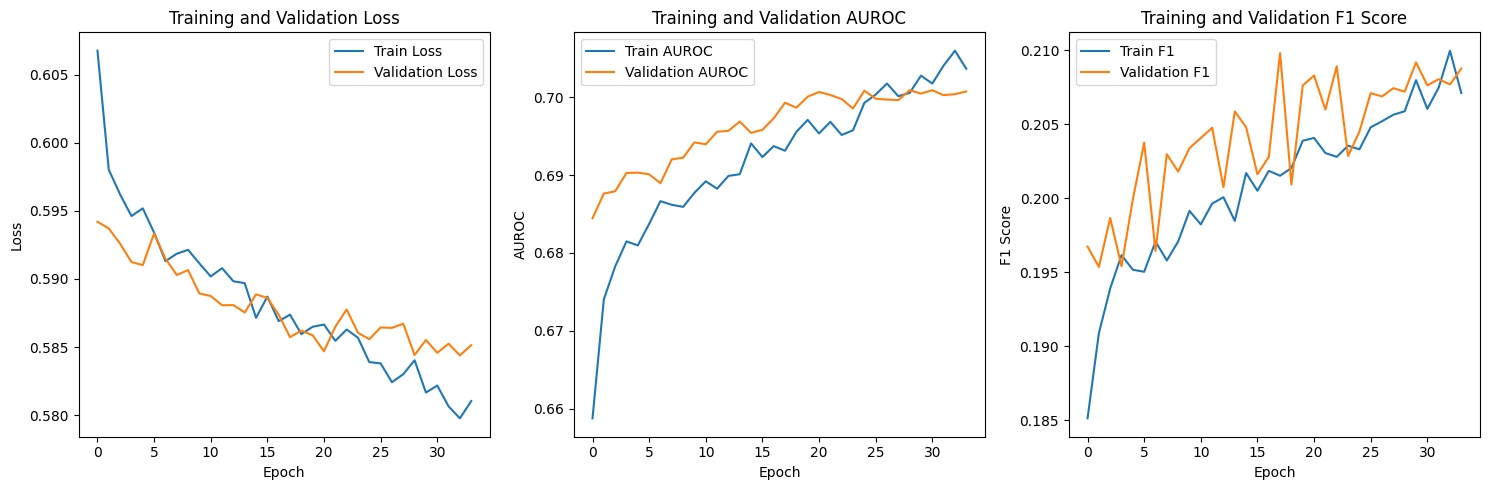

In [16]:
# Main training loop
best_val_auroc = 0
best_model_state = None
early_stopping = EarlyStopping(patience=5)

# Lists to store metrics
train_metrics_history = []
val_metrics_history = []

print("Starting training...")
print("Epoch\tTrain Loss\tTrain AUROC\tTrain F1\tTrain AP\tVal Loss\tVal AUROC\tVal F1\tVal AP")

for epoch in range(n_epochs):
    # Training phase
    train_metrics = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validation phase
    val_metrics = validate(model, val_loader)
    
    # Store metrics
    train_metrics_history.append(train_metrics)
    val_metrics_history.append(val_metrics)
    
    # Print metrics
    print(f"{epoch+1}\t{train_metrics['loss']:.4f}\t{train_metrics['auroc']:.4f}\t"
          f"{train_metrics['f1']:.4f}\t{train_metrics['avg_precision']:.4f}\t"
          f"{val_metrics['loss']:.4f}\t{val_metrics['auroc']:.4f}\t"
          f"{val_metrics['f1']:.4f}\t{val_metrics['avg_precision']:.4f}")
    
    # Print classification report every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nValidation Classification Report:")
        print(val_metrics['classification_report'])
    
    # Learning rate scheduling
    scheduler.step(val_metrics['auroc'])
    
    # Early stopping
    early_stopping(val_metrics['auroc'])
    
    # Save best model
    if val_metrics['auroc'] > best_val_auroc:
        best_val_auroc = val_metrics['auroc']
        best_model_state = model.state_dict().copy()
        print(f"\nNew best model saved with validation AUROC: {best_val_auroc:.4f}")
        print("Classification Report for Best Model:")
        print(val_metrics['classification_report'])
    
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)

# Plot training curves
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot([m['loss'] for m in train_metrics_history], label='Train Loss')
plt.plot([m['loss'] for m in val_metrics_history], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# AUROC plot
plt.subplot(1, 3, 2)
plt.plot([m['auroc'] for m in train_metrics_history], label='Train AUROC')
plt.plot([m['auroc'] for m in val_metrics_history], label='Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()
plt.title('Training and Validation AUROC')

# F1 Score plot
plt.subplot(1, 3, 3)
plt.plot([m['f1'] for m in train_metrics_history], label='Train F1')
plt.plot([m['f1'] for m in val_metrics_history], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()

### Hyperparameter Tuning

- learning_rates = [0.01, 0.001, 0.0005, 0.0001]
- dropout = [0.2, 0.3, 0.4]


Training with learning rate: 0.01
Epoch	Train Loss	Train AUROC	Train F1	Train AP	Val Loss	Val AUROC	Val F1	Val AP


/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6510	0.6646	0.1829	0.1218	0.6460	0.6827	0.1954	0.1327
2	0.6464	0.6740	0.1862	0.1264	0.6415	0.6862	0.1911	0.1354
3	0.6441	0.6780	0.1869	0.1305	0.6416	0.6900	0.2015	0.1379
4	0.6457	0.6775	0.1873	0.1297	0.6392	0.6891	0.1918	0.1372
5	0.6437	0.6791	0.1912	0.1280	0.6395	0.6895	0.1843	0.1382

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.54      0.69     35266
         1.0       0.11      0.73      0.18      2625

    accuracy                           0.55     37891
   macro avg       0.53      0.63      0.44     37891
weighted avg       0.90      0.55      0.65     37891

6	0.6418	0.6816	0.1896	0.1314	0.6401	0.6899	0.1947	0.1392
7	0.6404	0.6830	0.1904	0.1301	0.6401	0.6907	0.1912	0.1382
8	0.6405	0.6838	0.1916	0.1346	0.6379	0.6923	0.1989	0.1415
9	0.6391	0.6861	0.1948	0.1337	0.6364	0.6939	0.1955	0.1402
10	0.6384	0.6862	0.1921	0.1342	0.6398	0.6925	0.1894	0.1428

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6596	0.6468	0.1759	0.1132	0.6469	0.6829	0.1912	0.1364
2	0.6485	0.6709	0.1862	0.1254	0.6415	0.6866	0.1936	0.1377
3	0.6443	0.6768	0.1880	0.1268	0.6406	0.6892	0.1898	0.1387
4	0.6428	0.6776	0.1874	0.1289	0.6406	0.6877	0.1910	0.1366
5	0.6409	0.6810	0.1881	0.1290	0.6389	0.6903	0.1927	0.1384

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     35266
         1.0       0.11      0.69      0.19      2625

    accuracy                           0.60     37891
   macro avg       0.54      0.64      0.46     37891
weighted avg       0.90      0.60      0.70     37891

6	0.6408	0.6827	0.1876	0.1323	0.6393	0.6902	0.1914	0.1400
7	0.6399	0.6843	0.1900	0.1324	0.6379	0.6915	0.1908	0.1398
8	0.6416	0.6844	0.1889	0.1334	0.6370	0.6925	0.1946	0.1411
9	0.6397	0.6857	0.1875	0.1342	0.6368	0.6924	0.1898	0.1401
10	0.6374	0.6877	0.1917	0.1344	0.6370	0.6945	0.1954	0.1417

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6637	0.6407	0.1696	0.1135	0.6464	0.6816	0.1885	0.1338
2	0.6480	0.6689	0.1834	0.1252	0.6431	0.6845	0.1849	0.1350
3	0.6458	0.6746	0.1859	0.1257	0.6423	0.6853	0.1826	0.1345
4	0.6440	0.6758	0.1855	0.1280	0.6408	0.6871	0.1887	0.1373
5	0.6423	0.6787	0.1876	0.1284	0.6399	0.6869	0.1851	0.1371

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71     35266
         1.0       0.11      0.71      0.19      2625

    accuracy                           0.57     37891
   macro avg       0.53      0.63      0.45     37891
weighted avg       0.90      0.57      0.67     37891

6	0.6409	0.6799	0.1876	0.1305	0.6390	0.6892	0.1919	0.1385
7	0.6405	0.6834	0.1890	0.1318	0.6385	0.6906	0.1896	0.1388
8	0.6394	0.6833	0.1894	0.1330	0.6379	0.6912	0.1894	0.1391
9	0.6378	0.6852	0.1892	0.1327	0.6379	0.6904	0.1876	0.1392
10	0.6429	0.6829	0.1882	0.1338	0.6368	0.6912	0.1923	0.1392

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6881	0.5866	0.1448	0.0930	0.6578	0.6703	0.1701	0.1250
2	0.6652	0.6410	0.1681	0.1110	0.6498	0.6778	0.1792	0.1296
3	0.6589	0.6516	0.1735	0.1163	0.6465	0.6803	0.1840	0.1313
4	0.6544	0.6580	0.1775	0.1191	0.6450	0.6820	0.1831	0.1328
5	0.6520	0.6614	0.1798	0.1195	0.6433	0.6838	0.1876	0.1342

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71     35266
         1.0       0.11      0.71      0.19      2625

    accuracy                           0.57     37891
   macro avg       0.54      0.64      0.45     37891
weighted avg       0.90      0.57      0.67     37891

6	0.6504	0.6647	0.1813	0.1211	0.6425	0.6843	0.1883	0.1350
7	0.6506	0.6666	0.1816	0.1235	0.6423	0.6849	0.1896	0.1358
8	0.6475	0.6721	0.1840	0.1260	0.6422	0.6854	0.1895	0.1361
9	0.6465	0.6719	0.1840	0.1249	0.6417	0.6862	0.1870	0.1362
10	0.6452	0.6750	0.1863	0.1284	0.6407	0.6870	0.1902	0.1373

Validation Classification Report:
              precisio

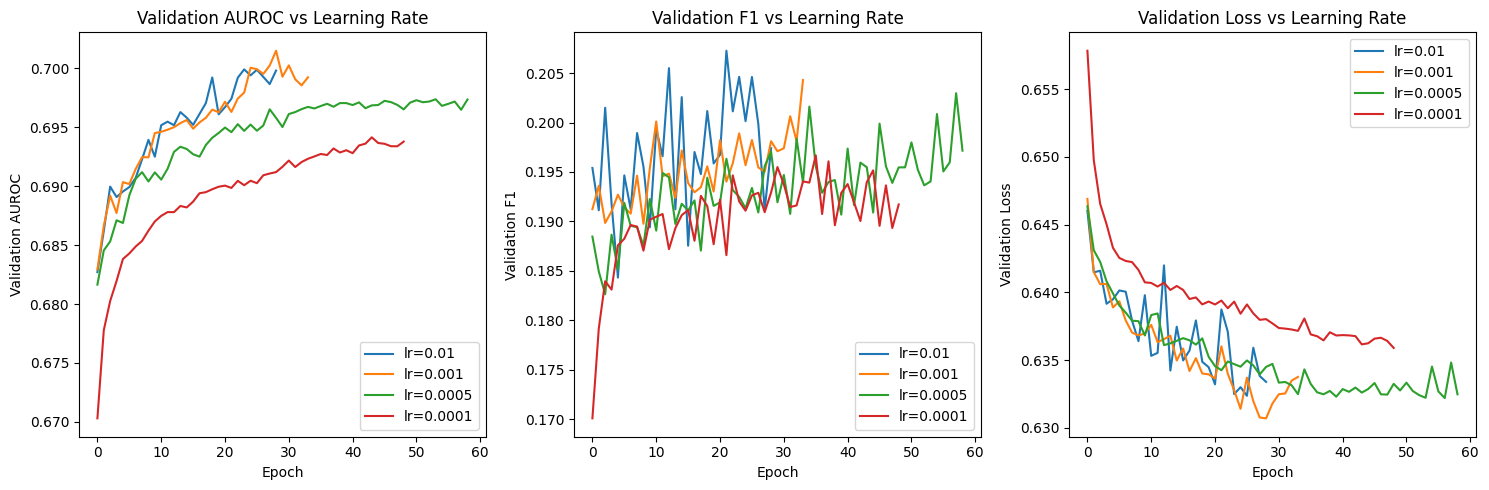


Best Results Summary:

Learning Rate: 0.01
Best Validation AUROC: 0.6999

Learning Rate: 0.001
Best Validation AUROC: 0.7015

Learning Rate: 0.0005
Best Validation AUROC: 0.6974

Learning Rate: 0.0001
Best Validation AUROC: 0.6941


In [58]:
# Learning rate experiments
learning_rates = [0.01, 0.001, 0.0005, 0.0001]
lr_results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    
    # Initialize model
    model = LoanDefaultModel(input_dim=24)
    model = model.to(device)
    
    # Optimizer with current learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True
    )
    
    # Training setup
    best_val_auroc = 0
    best_model_state = None
    early_stopping = EarlyStopping(patience=5)
    
    # Lists to store metrics
    train_metrics_history = []
    val_metrics_history = []
    
    print("Epoch\tTrain Loss\tTrain AUROC\tTrain F1\tTrain AP\tVal Loss\tVal AUROC\tVal F1\tVal AP")
    
    for epoch in range(n_epochs):
        train_metrics = train_epoch(model, train_loader, criterion, optimizer)
        val_metrics = validate(model, val_loader)
        
        train_metrics_history.append(train_metrics)
        val_metrics_history.append(val_metrics)
        
        print(f"{epoch+1}\t{train_metrics['loss']:.4f}\t{train_metrics['auroc']:.4f}\t"
              f"{train_metrics['f1']:.4f}\t{train_metrics['avg_precision']:.4f}\t"
              f"{val_metrics['loss']:.4f}\t{val_metrics['auroc']:.4f}\t"
              f"{val_metrics['f1']:.4f}\t{val_metrics['avg_precision']:.4f}")
        
        if (epoch + 1) % 5 == 0:
            print("\nValidation Classification Report:")
            print(val_metrics['classification_report'])
        
        scheduler.step(val_metrics['auroc'])
        early_stopping(val_metrics['auroc'])
        
        if val_metrics['auroc'] > best_val_auroc:
            best_val_auroc = val_metrics['auroc']
            best_model_state = model.state_dict().copy()
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Store results for this learning rate
    lr_results[lr] = {
        'best_val_auroc': best_val_auroc,
        'train_history': train_metrics_history,
        'val_history': val_metrics_history,
        'best_model_state': best_model_state
    }

# Plot comparison of learning rates
plt.figure(figsize=(15, 5))

# Plot validation AUROC for each learning rate
plt.subplot(1, 3, 1)
for lr in learning_rates:
    val_aurocs = [m['auroc'] for m in lr_results[lr]['val_history']]
    plt.plot(val_aurocs, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation AUROC')
plt.legend()
plt.title('Validation AUROC vs Learning Rate')

# Plot validation F1 for each learning rate
plt.subplot(1, 3, 2)
for lr in learning_rates:
    val_f1s = [m['f1'] for m in lr_results[lr]['val_history']]
    plt.plot(val_f1s, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation F1')
plt.legend()
plt.title('Validation F1 vs Learning Rate')

# Plot validation loss for each learning rate
plt.subplot(1, 3, 3)
for lr in learning_rates:
    val_losses = [m['loss'] for m in lr_results[lr]['val_history']]
    plt.plot(val_losses, label=f'lr={lr}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss vs Learning Rate')

plt.tight_layout()
plt.show()

# Print best results for each learning rate
print("\nBest Results Summary:")
for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    print(f"Best Validation AUROC: {lr_results[lr]['best_val_auroc']:.4f}")


Training with dropout rates: [0.2, 0.2, 0.2]
Epoch	Train Loss	Train AUROC	Train F1	Train AP	Val Loss	Val AUROC	Val F1	Val AP


/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6536	0.6580	0.1782	0.1200	0.6433	0.6842	0.1920	0.1349
2	0.6434	0.6766	0.1857	0.1297	0.6399	0.6889	0.1952	0.1377
3	0.6407	0.6810	0.1885	0.1323	0.6377	0.6905	0.1913	0.1382
4	0.6374	0.6858	0.1882	0.1358	0.6379	0.6910	0.1863	0.1383
5	0.6373	0.6863	0.1898	0.1354	0.6378	0.6935	0.1913	0.1391

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.59      0.73     35266
         1.0       0.11      0.69      0.19      2625

    accuracy                           0.60     37891
   macro avg       0.54      0.64      0.46     37891
weighted avg       0.90      0.60      0.69     37891

6	0.6356	0.6888	0.1907	0.1367	0.6366	0.6940	0.1944	0.1394
7	0.6347	0.6901	0.1923	0.1384	0.6368	0.6919	0.1957	0.1389
8	0.6360	0.6895	0.1921	0.1351	0.6353	0.6952	0.1963	0.1412
9	0.6355	0.6914	0.1907	0.1370	0.6366	0.6934	0.1951	0.1394
10	0.6347	0.6929	0.1934	0.1403	0.6368	0.6934	0.1950	0.1403

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6600	0.6497	0.1736	0.1131	0.6473	0.6816	0.1869	0.1324
2	0.6472	0.6705	0.1823	0.1246	0.6442	0.6847	0.1904	0.1369
3	0.6430	0.6776	0.1857	0.1295	0.6402	0.6872	0.1909	0.1372
4	0.6430	0.6793	0.1867	0.1298	0.6409	0.6884	0.1885	0.1377
5	0.6410	0.6817	0.1892	0.1313	0.6394	0.6894	0.1926	0.1384

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     35266
         1.0       0.11      0.68      0.19      2625

    accuracy                           0.60     37891
   macro avg       0.54      0.64      0.47     37891
weighted avg       0.90      0.60      0.70     37891

6	0.6403	0.6839	0.1896	0.1310	0.6388	0.6902	0.1926	0.1398
7	0.6396	0.6853	0.1898	0.1323	0.6411	0.6894	0.1946	0.1393
8	0.6395	0.6842	0.1884	0.1335	0.6373	0.6907	0.1889	0.1391
9	0.6375	0.6861	0.1895	0.1329	0.6389	0.6923	0.1946	0.1407
10	0.6374	0.6865	0.1893	0.1338	0.6369	0.6935	0.1933	0.1412

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6619	0.6416	0.1684	0.1128	0.6460	0.6812	0.1861	0.1341
2	0.6493	0.6674	0.1823	0.1226	0.6447	0.6852	0.1889	0.1349
3	0.6472	0.6714	0.1839	0.1246	0.6431	0.6858	0.1898	0.1352
4	0.6471	0.6739	0.1852	0.1264	0.6438	0.6858	0.1899	0.1346
5	0.6429	0.6773	0.1851	0.1284	0.6422	0.6872	0.1898	0.1366

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.58      0.72     35266
         1.0       0.11      0.70      0.19      2625

    accuracy                           0.59     37891
   macro avg       0.54      0.64      0.46     37891
weighted avg       0.90      0.59      0.69     37891

6	0.6411	0.6813	0.1868	0.1310	0.6407	0.6891	0.1960	0.1376
7	0.6425	0.6801	0.1883	0.1298	0.6399	0.6893	0.1934	0.1382
8	0.6412	0.6807	0.1865	0.1299	0.6399	0.6894	0.1868	0.1377
9	0.6401	0.6827	0.1869	0.1317	0.6403	0.6883	0.1883	0.1379
10	0.6404	0.6834	0.1871	0.1316	0.6398	0.6908	0.1930	0.1398

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6593	0.6491	0.1748	0.1171	0.6459	0.6823	0.1928	0.1359
2	0.6480	0.6695	0.1833	0.1226	0.6444	0.6843	0.1908	0.1368
3	0.6438	0.6754	0.1853	0.1283	0.6413	0.6887	0.1908	0.1382
4	0.6422	0.6796	0.1868	0.1298	0.6409	0.6876	0.1911	0.1374
5	0.6410	0.6811	0.1865	0.1314	0.6398	0.6897	0.1935	0.1381

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.59      0.73     35266
         1.0       0.11      0.70      0.19      2625

    accuracy                           0.60     37891
   macro avg       0.54      0.64      0.46     37891
weighted avg       0.90      0.60      0.70     37891

6	0.6395	0.6818	0.1875	0.1322	0.6383	0.6907	0.1957	0.1393
7	0.6401	0.6830	0.1881	0.1316	0.6398	0.6898	0.1899	0.1384
8	0.6386	0.6845	0.1883	0.1326	0.6393	0.6915	0.1868	0.1391
9	0.6383	0.6848	0.1875	0.1323	0.6410	0.6918	0.1934	0.1399
10	0.6375	0.6872	0.1891	0.1345	0.6388	0.6913	0.1933	0.1398

Validation Classification Report:
              precisio

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


1	0.6573	0.6527	0.1737	0.1168	0.6432	0.6831	0.1901	0.1360
2	0.6461	0.6730	0.1845	0.1266	0.6424	0.6850	0.1851	0.1368
3	0.6432	0.6780	0.1866	0.1319	0.6400	0.6882	0.1910	0.1383
4	0.6409	0.6822	0.1884	0.1299	0.6397	0.6886	0.1927	0.1392
5	0.6396	0.6835	0.1877	0.1313	0.6399	0.6896	0.1946	0.1400

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.75     35266
         1.0       0.11      0.67      0.19      2625

    accuracy                           0.62     37891
   macro avg       0.54      0.64      0.47     37891
weighted avg       0.90      0.62      0.71     37891

6	0.6395	0.6845	0.1890	0.1309	0.6386	0.6901	0.1928	0.1402
7	0.6376	0.6861	0.1884	0.1352	0.6365	0.6928	0.1930	0.1410
8	0.6369	0.6875	0.1891	0.1345	0.6373	0.6942	0.1875	0.1422
9	0.6367	0.6880	0.1912	0.1368	0.6346	0.6942	0.1936	0.1427
10	0.6357	0.6902	0.1913	0.1365	0.6349	0.6951	0.1896	0.1420

Validation Classification Report:
              precisio

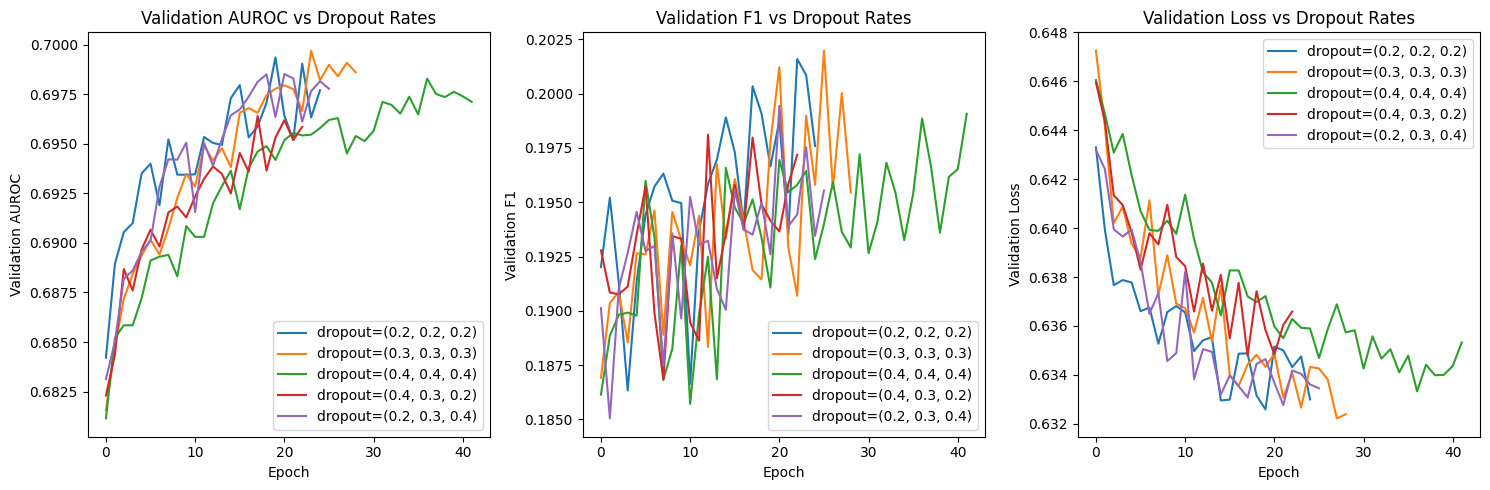


Best Results Summary:

Dropout Rates: (0.2, 0.2, 0.2)
Best Validation AUROC: 0.6994

Dropout Rates: (0.3, 0.3, 0.3)
Best Validation AUROC: 0.6997

Dropout Rates: (0.4, 0.4, 0.4)
Best Validation AUROC: 0.6983

Dropout Rates: (0.4, 0.3, 0.2)
Best Validation AUROC: 0.6964

Dropout Rates: (0.2, 0.3, 0.4)
Best Validation AUROC: 0.6985


In [59]:
# Dropout configurations to try
dropout_configs = [
    [0.2, 0.2, 0.2],  # Uniform low
    [0.3, 0.3, 0.3],  # Uniform medium (our current)
    [0.4, 0.4, 0.4],  # Uniform high
    [0.4, 0.3, 0.2],  # Decreasing
    [0.2, 0.3, 0.4]   # Increasing
]

dropout_results = {}

for config_idx, dropout_rates in enumerate(dropout_configs):
    print(f"\nTraining with dropout rates: {dropout_rates}")
    
    # Modified model class for different dropout rates
    class LoanDefaultModel(nn.Module):
        def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rates=dropout_rates):
            super(LoanDefaultModel, self).__init__()
            
            self.input_bn = nn.BatchNorm1d(input_dim)
            
            layers = []
            prev_dim = input_dim
            
            for i, hidden_dim in enumerate(hidden_dims):
                layers.extend([
                    nn.Linear(prev_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout_rates[i])
                ])
                prev_dim = hidden_dim
            
            self.hidden_layers = nn.Sequential(*layers)
            self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
        def forward(self, x):
            x = self.input_bn(x)
            x = self.hidden_layers(x)
            return torch.sigmoid(self.output_layer(x))

    # Initialize model
    model = LoanDefaultModel(input_dim=24)
    model = model.to(device)
    
    # Use the best learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    # Training setup
    best_val_auroc = 0
    best_model_state = None
    early_stopping = EarlyStopping(patience=5)
    
    train_metrics_history = []
    val_metrics_history = []
    
    print("Epoch\tTrain Loss\tTrain AUROC\tTrain F1\tTrain AP\tVal Loss\tVal AUROC\tVal F1\tVal AP")
    
    for epoch in range(n_epochs):
        train_metrics = train_epoch(model, train_loader, criterion, optimizer)
        val_metrics = validate(model, val_loader)
        
        train_metrics_history.append(train_metrics)
        val_metrics_history.append(val_metrics)
        
        print(f"{epoch+1}\t{train_metrics['loss']:.4f}\t{train_metrics['auroc']:.4f}\t"
              f"{train_metrics['f1']:.4f}\t{train_metrics['avg_precision']:.4f}\t"
              f"{val_metrics['loss']:.4f}\t{val_metrics['auroc']:.4f}\t"
              f"{val_metrics['f1']:.4f}\t{val_metrics['avg_precision']:.4f}")
        
        if (epoch + 1) % 5 == 0:
            print("\nValidation Classification Report:")
            print(val_metrics['classification_report'])
        
        scheduler.step(val_metrics['auroc'])
        early_stopping(val_metrics['auroc'])
        
        if val_metrics['auroc'] > best_val_auroc:
            best_val_auroc = val_metrics['auroc']
            best_model_state = model.state_dict().copy()
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    dropout_results[tuple(dropout_rates)] = {
        'best_val_auroc': best_val_auroc,
        'train_history': train_metrics_history,
        'val_history': val_metrics_history,
        'best_model_state': best_model_state
    }

# Plot comparison of dropout configurations
plt.figure(figsize=(15, 5))

# Plot validation AUROC for each config
plt.subplot(1, 3, 1)
for dropout_rates, results in dropout_results.items():
    val_aurocs = [m['auroc'] for m in results['val_history']]
    plt.plot(val_aurocs, label=f'dropout={dropout_rates}')
plt.xlabel('Epoch')
plt.ylabel('Validation AUROC')
plt.legend()
plt.title('Validation AUROC vs Dropout Rates')

# Plot validation F1 for each config
plt.subplot(1, 3, 2)
for dropout_rates, results in dropout_results.items():
    val_f1s = [m['f1'] for m in results['val_history']]
    plt.plot(val_f1s, label=f'dropout={dropout_rates}')
plt.xlabel('Epoch')
plt.ylabel('Validation F1')
plt.legend()
plt.title('Validation F1 vs Dropout Rates')

# Plot validation loss for each config
plt.subplot(1, 3, 3)
for dropout_rates, results in dropout_results.items():
    val_losses = [m['loss'] for m in results['val_history']]
    plt.plot(val_losses, label=f'dropout={dropout_rates}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss vs Dropout Rates')

plt.tight_layout()
plt.show()

# Print best results for each configuration
print("\nBest Results Summary:")
for dropout_rates, results in dropout_results.items():
    print(f"\nDropout Rates: {dropout_rates}")
    print(f"Best Validation AUROC: {results['best_val_auroc']:.4f}")

### Observations after trying different strategies
- Overall classification report after many experiments:
precision    recall  f1-score  support
0.0     0.96      0.61     0.74     35266
1.0     0.12      0.69     0.20      2625

The low precision (0.12) for class 1 (bad loans) indicates:
- Of all the loans we predict as "bad", only 12% are actually bad loans
- We're getting many false positives (good loans incorrectly classified as bad)

Potential reasons for this poor precision:
1. Severe Class Imbalance:
    - Training data has ~93% good loans vs ~7% bad loans
    - Even with class weights and balanced metrics, model struggles to learn true patterns of bad loans

2. Feature Information:
    - Current features might not be discriminative enough
    - Important signals for identifying bad loans might be missing
    - Existing features might have too much noise/overlap between classes

3. Problem Complexity:
    - Predicting loan defaults is inherently challenging
    - Good and bad loans might have very similar feature patterns
    - Some crucial factors in loan defaults might not be captured in the data

To potentially improve this, we can try:
1. More Feature Engineering:
    - Create more complex interactions between features
    - Domain-specific feature combinations
    - Polynomial features for non-linear relationships

2. Different Approaches to Handle Imbalance:
    - Different class weight calculations
    - SMOTENC (SMOTE for numerical and categorical features separately)
    - Ensemble methods with different sampling strategies

3. Model Architecture:
    - Wider networks to capture more complex patterns
    - Add skip connections
    - Try different activation functions




Test Set Performance:
--------------------------------------------------
Test Loss: 0.5867
Test AUROC: 0.6940
Test Average Precision: 0.1458
Test F1 Score: 0.2033

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     35266
         1.0       0.12      0.57      0.20      2626

    accuracy                           0.69     37892
   macro avg       0.54      0.63      0.51     37892
weighted avg       0.90      0.69      0.77     37892



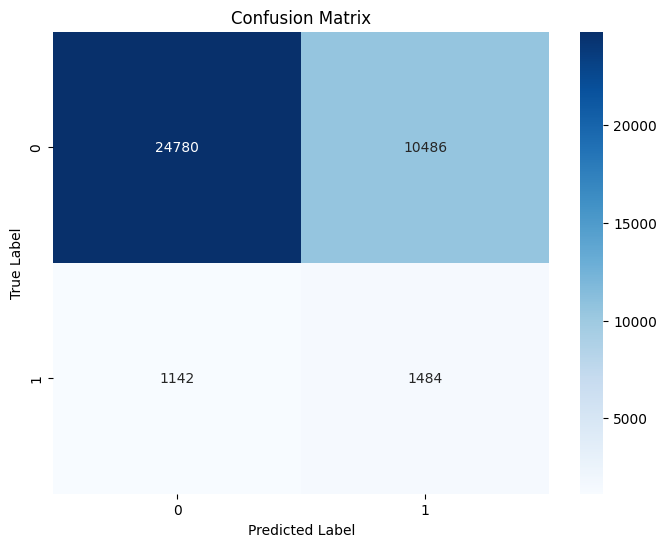

In [59]:
def evaluate_test_performance(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    # Calculate metrics
    test_loss = total_loss / len(test_loader)
    test_auroc = roc_auc_score(targets, predictions)
    test_avg_precision = average_precision_score(targets, predictions)
    test_f1 = f1_score(targets, binary_preds)
    
    print("\nTest Set Performance:")
    print("-" * 50)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test AUROC: {test_auroc:.4f}")
    print(f"Test Average Precision: {test_avg_precision:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(targets, binary_preds))
    
    return {
        'loss': test_loss,
        'auroc': test_auroc,
        'avg_precision': test_avg_precision,
        'f1': test_f1,
        'predictions': predictions,
        'binary_predictions': binary_preds,
        'targets': targets
    }

# Make sure best model is loaded
model.load_state_dict(best_model_state)
model.eval()

# Run evaluation on test set
test_results = evaluate_test_performance(model, test_loader, criterion)

# Optional: Save predictions for further analysis
test_predictions_df = pd.DataFrame({
    'true_values': test_results['targets'],
    'predicted_probs': test_results['predictions'],
    'predicted_class': test_results['binary_predictions']
})

# Print confusion matrix

plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_results['targets'], test_results['binary_predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [22]:
# Save preprocessing parameters
preprocessing_params = {
    # Scalers
    'scaler_dict': scaler_dict,  # Standard scalers for main features
    'derog_scaler': derog_scaler,  # Special scaler for mths_since_last_major_derog

    # Categorical encoding mappings
    'home_ownership_risk': home_ownership_risk,
    'purpose_groups': {
        'low_risk': low_risk_purpose,
        'medium_risk': medium_risk_purpose,
        'high_risk': high_risk_purpose
    },

    # Column lists
    'columns_to_drop': columns_to_drop,
    'scale_features': scale_features,
    'engineered_features': engineered_features,
    'feature_names': train_df.columns.tolist(),  # Final feature order

    # Feature engineering parameters
    'log_transform_features': ['annual_inc', 'loan_amnt', 'dti'],
    
    # Special handling flags
    'derog_special_value': -1  # Special value for no derogatory marks
}

# Save to file
import pickle
with open(os.path.join(path_to_py, "models", "processing_params.pkl"), 'wb') as f:
    pickle.dump(preprocessing_params, f)

In [23]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print(input_dim)

input_bn.weight 	 torch.Size([22])
input_bn.bias 	 torch.Size([22])
input_bn.running_mean 	 torch.Size([22])
input_bn.running_var 	 torch.Size([22])
input_bn.num_batches_tracked 	 torch.Size([])
hidden_layers.0.weight 	 torch.Size([128, 22])
hidden_layers.0.bias 	 torch.Size([128])
hidden_layers.1.weight 	 torch.Size([128])
hidden_layers.1.bias 	 torch.Size([128])
hidden_layers.1.running_mean 	 torch.Size([128])
hidden_layers.1.running_var 	 torch.Size([128])
hidden_layers.1.num_batches_tracked 	 torch.Size([])
hidden_layers.4.weight 	 torch.Size([64, 128])
hidden_layers.4.bias 	 torch.Size([64])
hidden_layers.5.weight 	 torch.Size([64])
hidden_layers.5.bias 	 torch.Size([64])
hidden_layers.5.running_mean 	 torch.Size([64])
hidden_layers.5.running_var 	 torch.Size([64])
hidden_layers.5.num_batches_tracked 	 torch.Size([])
hidden_layers.8.weight 	 torch.Size([32, 64])
hidden_layers.8.bias 	 torch.Size([32])
hidden_layers.9.weight 	 torch.Size([32])
hidden_layers.9.bias 	 torch.Size([32]

In [24]:
# Save model
model_save_path = os.path.join(path_to_py, "models","loan_default_model.pth")
# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'hidden_dims': [128, 64, 32]
}, model_save_path)